In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

import frank_lab


In [2]:
#fileroot = '/Users/ckemere/Development/Data/Frank/Fra';
fileroot = 'SampleData/Fra';



In [3]:
[cellinfo,rawcellinfo] = frank_lab.load_data(fileroot, datatype='cellinfo')
#cellinfo[pd.isnull(cellinfo['area'])]
tetinfo,_ = frank_lab.load_data(fileroot, datatype='tetinfo')



Loading fracellinfo00.mat
Loading fratetinfo.mat


In [4]:
# These are all zero indexed in contrast to their matlab counterparts
Day = 4
Epoch = 5
Tetrode = 9

task = frank_lab.load_data(fileroot, day=Day+1, datatype='task')
task[Day][Epoch].description


Loading fratask05.mat


'TrackA'

In [5]:

# Now, want to generate synthetic data to mimic each tetrode, then detect ripples on them, 
# then generate the ROC plots using m of N rules

eeg = frank_lab.load_data(fileroot, day=Day+1, epoch=Epoch+1, tetrode=Tetrode+1)[Day][Epoch][Tetrode]
#eeg.__dict__ to get fields
data = eeg.data
FS = eeg.samprate
StartTime = eeg.starttime
TimeAxis = StartTime + np.array(range(len(data))) / FS

print('{} minutes of data.'.format(len(data)/FS/60))


Loading fraeeg05-6-10.mat
15.266888888888873 minutes of data.


In [6]:
pos = frank_lab.load_data(fileroot, day=Day+1, datatype='pos')


Loading frapos05.mat


In [7]:
b = signal.firwin(25, [150/(FS/2), 250/(FS/2)], pass_zero=False)
ripple_data = signal.filtfilt(b,1,data);


In [8]:
import numpy as np
import scipy.stats
def generate_SWR(PeakLevel, ThresholdFraction=0.6, PeriodAboveThreshold=0.015, FS=30000, FRipple=200, nStdDevs=4, PhaseOffset=0) :
    sigma = PeriodAboveThreshold/2 / np.sqrt(-2 * np.log(ThresholdFraction))
    winSize = round(nStdDevs * sigma * FS)
    t = np.arange(-winSize, winSize+1) / FS
    envelope = scipy.stats.norm.pdf(t, 0, sigma)
    envelope = (envelope/envelope.max()) * PeakLevel
    carrier = np.sin(2*np.pi*FRipple*t + PhaseOffset) * envelope
    return carrier, t, envelope




In [9]:
def evaluate_ripple_detection(ActualEvents, PutativeEvents, LargestLatency, AllowNonCausal=False, MaskLockouts=True):
    if (AllowNonCausal):
        PotentialFalsePositives  = np.array([ActualEvents[k] for k in map(lambda x: (np.abs(ActualEvents - x)).argmin(), PutativeEvents)])
        FalsePositives = np.argwhere(np.abs(PutativeEvents - PotentialFalsePositives) > LargestLatency).squeeze()
        TruePositives = np.argwhere(np.abs(PutativeEvents - PotentialFalsePositives) <= LargestLatency).squeeze()
        
        # Get rid of repeats
        uniques, counts = np.unique(PotentialFalsePositives[TruePositives], return_counts=True)
        Mask = np.ones(TruePositives.shape,dtype=bool)
        for i, u in enumerate(uniques):
            if(counts[i] > 1):
                repeat_idx = np.argwhere(PotentialFalsePositives[TruePositives] == u).squeeze()
                best = np.abs(PotentialFalsePositives[TruePositives[repeat_idx]] - PutativeEvents[TruePositives[repeat_idx]]).argmin()
                repeat_idx = np.delete(repeat_idx, best)
                Mask[repeat_idx] = False          
        FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
        TruePositives = TruePositives[Mask]


        PotentialMisses = np.array([PutativeEvents[k] for k in map(lambda x: (np.abs(PutativeEvents - x)).argmin(), ActualEvents)])
        Misses = np.argwhere(np.abs(ActualEvents - PotentialMisses) > LargestLatency)
    else:
        PotentialFalsePositives  = np.array([ActualEvents[k] for k in map(lambda x: np.where((x - ActualEvents) >= 0, (x - ActualEvents), np.infty).argmin(), PutativeEvents)])
        FalsePositives = np.argwhere((PutativeEvents - PotentialFalsePositives > LargestLatency) | 
                                     (PutativeEvents - PotentialFalsePositives < 0)).squeeze()
        TruePositives = np.argwhere((PutativeEvents - PotentialFalsePositives <= LargestLatency) &
                                    (PutativeEvents - PotentialFalsePositives > 0)).squeeze()
        
        # Get rid of repeats
        uniques, counts = np.unique(PotentialFalsePositives[TruePositives], return_counts=True)
        Mask = np.ones(TruePositives.shape,dtype=bool)
        for i, u in enumerate(uniques):
            if(counts[i] > 1):
                repeat_idx = np.argwhere(PotentialFalsePositives[TruePositives] == u).squeeze()
                best = (PutativeEvents[TruePositives[repeat_idx]] - PotentialFalsePositives[TruePositives[repeat_idx]]).argmin()
                repeat_idx = np.delete(repeat_idx, best)
                Mask[repeat_idx] = False          
        FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
        TruePositives = TruePositives[Mask]
        
        # Potentially look for lockout periods that might have blocked detection (in low threshold cases)
        # Assuming LockoutPeriod and LargestLatency are the same!!!!!
        if (MaskLockouts):
            Mask = np.ones(TruePositives.shape,dtype=bool)
            for idx,k in enumerate(TruePositives):
                if (k > 0):
                    # Flag events where the previous putative event was within a lockout period of the actual event
                    if ((PotentialFalsePositives[k] - PutativeEvents[k - 1]) < LargestLatency) :
                        Mask[idx] = False
            FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
            TruePositives = TruePositives[Mask]

        PotentialMisses = np.array([PutativeEvents[k] for k in map(lambda x: (np.where(PutativeEvents - x >= 0, PutativeEvents - x, np.infty)).argmin(), ActualEvents)])
        Misses = np.argwhere(PotentialMisses - ActualEvents > LargestLatency).squeeze()

    Latencies = PutativeEvents[TruePositives] - PotentialFalsePositives[TruePositives]
    
    return FalsePositives, TruePositives, Latencies, Misses


In [10]:
# For a given "SNR", the hilbert transform version will have some false positives
# For real-time versions:
#  - compare false positive rate (and misses) to hilbert transform version and ground truth
#  - compare detection latency relative to center, hilbert transform peak, and hilbert transform start
#
# What does realtime look like?
# 1.) filter
# 2.) abs(value)
# 3.) smooth?
# 4.) train on std and mean
# 5.) detect
# 6.) lock out for some period of time and then start again
#
# Implement 1-3 as a function which takes input and returns output

In [11]:
import numpy as np
def ripple_processor(data, FS=1500, TrainingPeriod=120*FS, ThresholdSigma=4, LockoutPeriod=0.25*FS, Algorithm="unsmooth"):
    def find_events(d, Thresh, TrainBnd, LckPd):
        events = np.argwhere(d > Thresh)
        # get rid of events that happened during training
        events = events[events >= TrainBnd]
        # get rid of events which lie within the Lockout period of previous events
        mask = np.ones(len(events), dtype=bool)
        last = -LckPd -1
        for k, ev in enumerate(events):
            if (ev < last + LckPd):
                mask[k] = False
            else:
                last = ev
        events = events[mask]
        return events

    TrBnd = np.rint(TrainingPeriod).astype(int)
    LckPd = np.rint(LockoutPeriod)
    b, a = scipy.signal.butter(4, [150/(FS/2), 250/(FS/2)], btype='bandpass')
    ripple_band = scipy.signal.lfilter(b, a, data) # causal fitler of signal
    
    if (Algorithm.lower()=="unsmooth"):
        ripple_signal = np.abs(ripple_band)
        mu = np.mean(ripple_signal[:TrBnd])
        sd = np.std(ripple_signal[:TrBnd])
        ripple_events = find_events(ripple_signal, mu + ThresholdSigma*sd, TrBnd, LckPd)
    
    elif (Algorithm.lower()=="smooth"):
        bsmooth, asmooth = scipy.signal.butter(2, 50/(FS/2), btype='lowpass')
        ripple_signal = scipy.signal.lfilter(bsmooth, asmooth, np.abs(ripple_band)) #smooth it
        mu = np.mean(ripple_signal[:TrBnd])
        sd = np.std(ripple_signal[:TrBnd])
        ripple_events = find_events(ripple_signal, mu + ThresholdSigma*sd, TrBnd, LckPd)
        
    elif (Algorithm.lower()=="hbt"):
        g = np.zeros(20)
        gptr = 0
        last_stim = 0
        def updateGain(d, g, gptr):
            mn = g.mean()
            g[gptr] = d
            gptr = gptr + 1 if (gptr < 19) else 0
            return mn, g, gptr
        
        mu = 0
        sd = 0
        ripple_events = []
        v = np.zeros(ripple_band.shape)
        # Algorithm from Jadhav et al Science 2012
        for k, x in enumerate(ripple_band):
            if (k > 0):
                df = x - v[k-1]
            else:
                df = x

            if (df > 0):
                gain, g, gptr = updateGain(1.2, g, gptr)
                v[k] = v[k-1] + gain * df
            else:
                _, g, gptr = updateGain(2.0, g, gptr)
                v[k] = v[k-1] + 2.0 * df
                
            mu = mu + (x - mu) / 10000
            sd = (np.abs(x - mu) - sd) / 10000 + sd
            if ((k > TrBnd) & ((k-last_stim) > LckPd)) :
                if (v[k] > mu + ThresholdSigma*sd) :
                    ripple_events.append(k)
                    last_stim = k
        ripple_events = np.array(ripple_events)
        ripple_signal = v
    else:
        raise ValueError("Unknown algorithm specified")
    
    return ripple_events, ripple_signal, mu, sd, ripple_band

In [12]:
import ripples

def generate_fake_ripple_data(DataStdDev, Length, RipTimes, Peak, ThresholdFraction, PeriodAboveThreshold, LargestLatency) :
    # Generate a colored (i.e., filtered white) noise process with same mean and std as ripples
    b = signal.firwin(25, [150/(FS/2), 250/(FS/2)], pass_zero=False)
    fake_ripples = signal.filtfilt(b,1,np.random.randn(Length));
    fake_ripples = fake_ripples / np.std(fake_ripples) # Make unity power
    fake_ripples = fake_ripples * DataStdDev; # Scale by power of measured ripples

    PhaseOffsets = np.random.rand(len(RipTimes))*2*np.pi

    for k in range(NRipsToAdd):
        x,t, _ = generate_SWR(Peak, ThresholdFraction=ThresholdFraction, 
                              PeriodAboveThreshold=PeriodAboveThreshold,
                              PhaseOffset=PhaseOffsets[k])
        fake_ripples[(np.rint(t * FS) + RippleInsertionIdx[k]).astype(int)] += x


    fake_ripple_bounds, fake_ripple_maxes, fake_ripple_events, _, _, _ = \
        ripples.detect(fake_ripples, FS=FS, ThresholdSigma=Threshold)

    #print('Number of ripples injected: {:4d}. Number detected: {:4d}.'.format(NRipsToAdd, len(fake_ripple_maxes)))
    #print('Approximate signal power: {}. Approximate noise power: {}.'.format(np.var(x), DataStdDev**2))
    
    FalsePositives, TruePositives, Latencies, Misses = evaluate_ripple_detection(RippleInsertionIdx, 
                                        fake_ripple_bounds[:,0], 
                                        LargestLatency,
                                        AllowNonCausal=True)

    rip_times = fake_ripple_bounds[TruePositives,0]
    
    return fake_ripples, fake_ripple_bounds[TruePositives,:], fake_ripple_events[TruePositives,:]

In [13]:
Threshold = 3.5 # standard deviations above the mean
ripple_events, ripple_maxes, ripple_bounds, ripple_signal, ripple_envelope, smoothed_envelope = \
    ripples.detect(data, FS=FS, ThresholdSigma=Threshold)
    
PeriodAboveThreshold = np.mean(np.diff(ripple_events)) / FS
Peak = np.mean(ripple_maxes)
ThresholdFraction = Threshold / (Peak / np.std(smoothed_envelope))
print((len(ripple_maxes), PeriodAboveThreshold, Peak, ThresholdFraction))
   
NRipsToAdd = 100 # len(ripple_maxes)
EdgeExclude = FS*10
RippleInsertionIdx = np.rint(np.linspace(EdgeExclude, len(data) - EdgeExclude, NRipsToAdd))


LargestLatency = 0.25 * FS
TrainingPeriod = 120 * FS



(74, 0.089990990990990893, 39.132269480077539, 0.36943658867585211)


In [14]:


def test_threshold(ThreshSigma, Data, TrueTimes, TrainingPeriod, LargestLatency):
    rip_evs,_,_,_,_ = ripple_processor(Data, ThresholdSigma=ThreshSigma, TrainingPeriod=TrainingPeriod, 
                                       LockoutPeriod=LargestLatency)
    fps, tps, latencies, _  = evaluate_ripple_detection(TrueTimes, rip_evs,LargestLatency)
    FalsePositives = [len(fps)]
    DetectedRipples = [len(tps)]
    MeanLatencies = [np.mean(latencies)]
    StdLatencies = [np.std(latencies)]

    rip_evs,_,_,_,_ = ripple_processor(Data, ThresholdSigma=ThreshSigma, 
                                                          TrainingPeriod=TrainingPeriod, Algorithm="smooth")
    fps, tps, latencies, _  = evaluate_ripple_detection(TrueTimes, rip_evs, LargestLatency)
    FalsePositives.append(len(fps))
    DetectedRipples.append(len(tps))
    MeanLatencies.append(np.mean(latencies))
    StdLatencies.append(np.std(latencies))

    rip_evs,_,_,_,_ = ripple_processor(Data, ThresholdSigma=ThreshSigma, 
                                                          TrainingPeriod=TrainingPeriod, Algorithm="hbt")
    fps, tps, latencies, _  = evaluate_ripple_detection(TrueTimes, rip_evs, LargestLatency)
    FalsePositives.append(len(fps))
    DetectedRipples.append(len(tps))
    MeanLatencies.append(np.mean(latencies))
    StdLatencies.append(np.std(latencies))
    
    return FalsePositives, DetectedRipples, MeanLatencies, StdLatencies
   




In [15]:
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory

import time

In [16]:
ThresholdSigmas = np.arange(2.5,8,0.5)

FPs = []
Detected = []
MnLat = []
SdLat = []

NumberOfRepeats = 2

for k in range(NumberOfRepeats):
    print(k)
    SynthRipples, SynthRippleBounds, SynthRippleInnerBounds = \
        generate_fake_ripple_data(np.std(ripple_signal), len(data), RippleInsertionIdx, Peak, 
                                  ThresholdFraction, PeriodAboveThreshold, LargestLatency)

    NonTrainingRipTimes = SynthRippleBounds[SynthRippleBounds[:,0] > TrainingPeriod,0]

    #results = [test_threshold(ts, SynthRipples, NonTrainingRipTimes, TrainingPeriod, LargestLatency) for ts in ThresholdSigmas]
    results = Parallel(n_jobs=14)(delayed(test_threshold)(ts, SynthRipples, NonTrainingRipTimes, TrainingPeriod, LargestLatency) for ts in ThresholdSigmas)
    fp, detrip, mlat, stdlat = zip(*results)
    FPs.append(np.array(fp))
    Detected.append(np.array(detrip))
    MnLat.append(np.array(mlat))
    SdLat.append(np.array(stdlat))
    

Number of ripples injected:  100. Number detected:  100.
Approximate signal power: 169.62025961226163. Approximate noise power: 53.00018056970831.
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
Elapsed time: 51.039225339889526
Number of ripples injected:  100. Number detected:  101.
Approximate signal power: 169.62025960027. Approximate noise power: 53.00018056970831.
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
Elapsed time: 61.5045006275177
Number of ripples injected:  100. Number detected:  100.
Approximate signal power: 169.62025960002322. Approximate noise power: 53.00018056970831.
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
Elapsed time: 59.4677939414978
Number of ripples injected:  100. Number detected:  102.
Approximate signal power: 169.62025960676254. Approximate noise power: 53.00018056970831.
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
Elapsed time: 63.91246819496155
Number of ripples injected:  100. Number detected:  101.
Approximate signal power: 169.620259605025. Approximate

In [23]:
FalsePositiveRate = np.array(FPs)/len(NonTrainingRipTimes)
MissedRate = 1 - np.array(Detected)/len(NonTrainingRipTimes)
Latencies = np.array(MnLat)/FS

In [24]:
FalsePositiveRate.shape

(20, 11, 3)

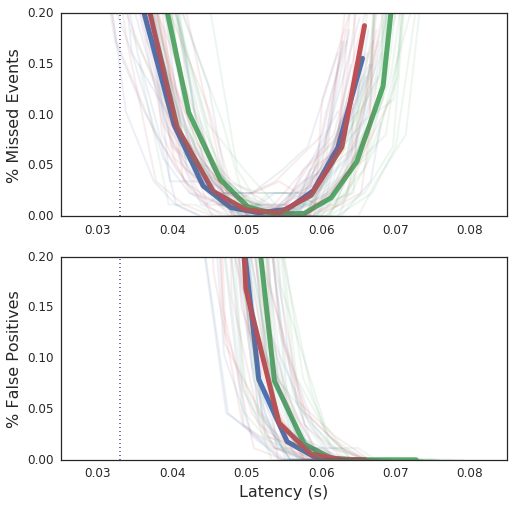

In [50]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
sns.set(rc={'figure.figsize': (8, 8),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

from matplotlib import gridspec
gs = gridspec.GridSpec(2, 1) 
misses = plt.subplot(gs[0])
miss_rate = plt.plot(np.mean(Latencies, axis=0), np.mean(MissedRate,axis=0), linewidth=5)
colors = [x.get_color() for x in miss_rate]
for k in range(20):
    for i in range(3):
        plt.plot(Latencies[k,:,i],MissedRate[k,:,i], alpha=0.1, color=colors[i])

plt.plot(np.mean(SynthRippleInnerBounds[:,0] - SynthRippleBounds[:,0])*np.ones(2)/FS,[0,1],':')
plt.ylabel('% Missed Events')

falpos = plt.subplot(gs[1], sharex=misses, sharey=misses)
false_pos = plt.plot(np.mean(Latencies, axis=0), np.mean(FalsePositiveRate,axis=0), linewidth=5)
colors = [x.get_color() for x in false_pos]
for k in range(20):
    for i in range(3):
        plt.plot(Latencies[k,:,i],FalsePositiveRate[k,:,i], alpha=0.1, color=colors[i])

#plt.legend(miss_rate+false_pos, ['$Miss_{abs}$', '$Miss_{smooth}$', 
#                                 '$Miss_{hbt}$','$FP_{abs}$', '$FP_{smooth}$', '$FP_{hbt}$'])
plt.plot(np.mean(SynthRippleInnerBounds[:,0] - SynthRippleBounds[:,0])*np.ones(2)/FS,[0,1],':')
plt.gca().set_ylim([0,0.2])
plt.gca().set_xlim([0.025,0.085])
plt.ylabel('% False Positives')
plt.xlabel('Latency (s)')
plt.savefig('3_5sigmaRipples-Performance.png')
plt.show()
plt.close()


In [29]:
[x.get_color() for x in miss_rate]

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]

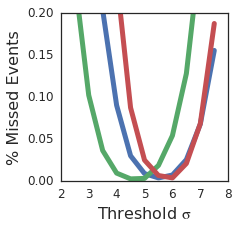

In [49]:

sns.set(rc={'figure.figsize': (3, 3),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

false_pos = plt.plot(ThresholdSigmas, np.mean(MissedRate,axis=0), linewidth=5)
plt.xlabel('Threshold $\sigma$')
plt.ylabel('% Missed Events')
plt.gca().set_ylim([0,0.2])
plt.savefig('3_5sigmaRipples-Threshold.png')
plt.show()
plt.close()